<a href="https://colab.research.google.com/github/LucasHenrique-dev/projeto-QTS/blob/main/desenvolvimento/GeradrorQTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importar Bibliotecas

In [128]:
import time
import random
import math
import sys
import json
import matplotlib.pyplot as plt
# libraries for the files in google drive
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

## Importar Informações

In [129]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1Zv5i7SI4MMgMzSQjeBIS9q2AMAkbA0bX' #<-- You add in here the id from you google drive file, you can find it


download = drive.CreateFile({'id': file_id})


# Download the file to a local disc
download.GetContentFile('info_curso.json')

##Explorar Dados do Curso

In [130]:
arquivo = open('/content/info_curso.json')
curso = json.load(arquivo)

print(json.dumps(curso, indent=4))

{
    "horario_inicio": "7:00",
    "horario_fim": "12:00",
    "quantidade_turmas": 5,
    "maximo_aulas_dia": 2,
    "disciplinas": {
        "SO": {
            "nome": "Sistemas Operacionais",
            "hora_aula": 1,
            "carga_horaria_semanal": 4
        },
        "MF": {
            "nome": "M\u00e9todos Formais",
            "hora_aula": 1,
            "carga_horaria_semanal": 4
        },
        "OC": {
            "nome": "Organiza\u00e7\u00e3o de Computadores",
            "hora_aula": 1,
            "carga_horaria_semanal": 4
        },
        "CO": {
            "nome": "Compiladores",
            "hora_aula": 1,
            "carga_horaria_semanal": 4
        },
        "IA": {
            "nome": "Intelig\u00eancia Artificial",
            "hora_aula": 1,
            "carga_horaria_semanal": 4
        }
    }
}


In [131]:
disciplinas = {0: ('NA', 'Horário Vago')}

for index, disciplina in enumerate(curso["disciplinas"].items()):
  disciplinas[index+1] = (disciplina[0], disciplina[1]["nome"])

disciplinas

{0: ('NA', 'Horário Vago'),
 1: ('SO', 'Sistemas Operacionais'),
 2: ('MF', 'Métodos Formais'),
 3: ('OC', 'Organização de Computadores'),
 4: ('CO', 'Compiladores'),
 5: ('IA', 'Inteligência Artificial')}

## Funções e Veriáveis Auxiliares

In [132]:
def converter_minutos(hora):
  t = time.strptime(hora, '%H:%M')
  minutos = t[3] * 60 + t[4]
  return minutos

In [133]:
def calcular_disciplinas_dia(curso, segmentacao_horario):
  inicio, fim = curso['horario_inicio'], curso['horario_fim']
  inicio, fim = converter_minutos(inicio), converter_minutos(fim)
  return ((fim - inicio)/segmentacao_horario) + 1

In [134]:
dias_semana = ['Segunda','Terça','Quarta','Quinta','Sexta']

## Objetivos e Restrições do Sistema

O algoritmo visa montar um quadro de trabalho semanal (QTS) que otimize certos aspectos

- Objetivos:
  - Menor Tempo de Espera Entre Aulas: horário de aula vaga entre aulas da mesma disciplina

Além disso, deverá respeitar certas restrições

- Restrições:
  - Hora aula semanal: cada disciplina possui uma carga horária que deve ser cumprida ao longo da semana
  - Aulas conjuntas: disciplinas devem ser lecionadas em forma de grupos. Ex.: 2 aulas seguidas da disciplina A, 3 aulas seguidas da disciplina B, etc


## Funções de Avaliação

### Avaliar Objetivos

#### OBJETIVO 1: TEMPO DE OCIOSIDADE ENTRE AULAS DE MESMA DISCIPLINA

In [135]:
def calcular_horas_vagas(aulas):
  disciplinas = set(aulas);
  aula_vaga = 0

  for disciplina in disciplinas:
    if disciplina == 0:                                                         #Ignora aulas vagas
      continue

    aula_atual = proxima_aula = 0
    while aulas[proxima_aula:].count(disciplina) > 1:                           #Calcula horas vagas de uma disciplina
      # print("Aula Atual: ", aula_atual, "     Proxima Aula: ", proxima_aula)
      aula_atual = aulas.index(disciplina, proxima_aula)
      proxima_aula = aulas.index(disciplina, aula_atual+1)

      aula_vaga += proxima_aula - (aula_atual + 1)

  return aula_vaga

In [136]:
calcular_horas_vagas([2, 0, 2, 2, 0])

1

### Avaliar Restrições

#### RESTRIÇÃO 2: AULAS CONJUNTAS

In [137]:
def calcular_aulas_esparsas(aulas, agrupamento):
  tamanho_grupo_aulas = aulas_esparsas = count = 0
  indices = [0]

  while count <= len(aulas) - agrupamento:
    if aulas[count] == 0:                                             #Não agrupa aulas vagas
      count += 1
      indices += [count]
      continue

    tamanho_grupo_aulas = len(set(aulas[count:count+agrupamento]))
   
    if 0 in aulas[count:count+agrupamento]:                           #Ignora aulas vagas
      # print("Grupo Aula Vaga:", aulas[count:count+agrupamento])
      aulas_esparsas += tamanho_grupo_aulas - 1
      count += 1
    elif tamanho_grupo_aulas == 1:                                    #Aulas agrupadas
      # print("Grupo:", aulas[count:count+agrupamento])
      count += agrupamento
    else:                                                             #Aulas não agrupadas
      # print("Não Grupo:", aulas[count:count+agrupamento])
      aulas_esparsas += tamanho_grupo_aulas
      count += 1
    
    indices += [count]

  tamanho_grupo_aulas = len(set(aulas[count:]))                       #Aulas desagrupadas (grupo menor do que deveria)

  if 0 in aulas[count:]:                                              #Ignora aulas vagas
    tamanho_grupo_aulas -= 1

  if len(set(aulas[count - agrupamento:count])) == 1:                 #Desagrupados (aula agrupada anterior)
    if len(aulas[indices[-2]:indices[-1]]) == agrupamento:
      # print("Desagrupados:", aulas[count:])
      aulas_esparsas += tamanho_grupo_aulas
  elif aulas[count-1] == 0:                                           #Desagrupados (aula vaga anterior)
    # print("Desagrupados:", aulas[count:])
    aulas_esparsas += tamanho_grupo_aulas

  return aulas_esparsas

In [138]:
calcular_aulas_esparsas([1,1,1,0,1,1], 3)                             #Desagrupados (aula vaga anterior)

1

In [139]:
calcular_aulas_esparsas([1,1,2,2,3,3,4,3,3,3], 2)                     #Desagrupados (aula agrupada anterior)

3

In [140]:
def verificar_aulas_esparsas(aulas, agrupamento= 2):
  count = tamanho_grupo_aulas = 0

  while count <= len(aulas) - agrupamento:
    if aulas[count] == 0:                                           #Não agrupa aulas vagas
      count += 1
      continue
    
    tamanho_grupo_aulas = len(set(aulas[count:count+agrupamento]))
   
    if tamanho_grupo_aulas == 1:                                    #Aulas agrupadas
      count += agrupamento
    else:                                                           #Aulas não agrupadas
      return True
  
  tamanho_grupo_aulas = len(set(aulas[count:]))
  
  if 0 in aulas[count:]:
    tamanho_grupo_aulas -= 1
    
  if tamanho_grupo_aulas:                                           #Aulas desagrupadas (grupo menor do que deveria)
    return True


  return False

In [141]:
verificar_aulas_esparsas([1,1,1,0,1,1], 3)                          #Desagrupados (aula vaga anterior)

True

In [142]:
verificar_aulas_esparsas([1,1,2,2,3,3,4,3,3,3], 2)                  #Desagrupados (aula agrupada anterior)

True

In [143]:
verificar_aulas_esparsas([1,1,2,2,3,3,4,4,3,3], 2)                  #Desagrupados (aula agrupada anterior)

False

In [144]:
verificar_aulas_esparsas([0,3,3,0,1], 2)                            #Desagrupados (aula agrupada anterior)

True

##Definir Cromossomo

Definir a sequência genética de formação de um cromossomo

Os genes determinam aspectos de um indivíduo e o cromossomo é o conjunto dessas características o qual forma o indivíduo (possível solução do problema)

O cromossomo está estruturado da seguinte forma:
- turma -> dias da semana -> disciplinas
- Não há divisão física entre os dados, eles são sequenciais
- As informações indicadas no primeiro tópico se repetem N vezes onde N indica o número de turmas

[Turma1:(Segunda:(..disciplinas), Terça:(..disciplinas), Quarta:(..disciplinas), Quinta:(..disciplinas), Sexta:(..disciplinas)), Turma2:(Segunda:(..disciplinas), Terça:(..disciplinas), Quarta:(..disciplinas), Quinta:(..disciplinas), Sexta:(..disciplinas))..]

Ex.: [(SO,SO,SO,SO,MF,MF), (MF,MF,OC,OC,OC,OC), (CO,CO,CO,CO,IA,IA), (IA,IA,NA,NA,NA,NA), (NA,NA,NA,NA,NA,NA),</br>
(SO,SO,SO,SO,MF,MF), (MF,MF,OC,OC,OC,OC), (CO,CO,CO,CO,IA,IA), (IA,IA,NA,NA,NA,NA), (NA,NA,NA,NA,NA,NA)]

In [145]:
segmentacao_horario = 60                                                        # Divisão do horário no QTS (minutos)
disciplinas_dia = int(calcular_disciplinas_dia(curso, segmentacao_horario))     # Retorna quantidade de sessões destinadas às disciplinas em um dia

In [146]:
disciplinas_dia

6

###Funções de Geração do Cromossomo

In [147]:
def gerar_aulas_conjuntas(tamanho_cromossomo, dominio):
  cromossomo, tamanho_grupo = [], curso["maximo_aulas_dia"]
  quantidade_semanas = tamanho_cromossomo // disciplinas_dia                  
  quantidade_grupos_aulas = disciplinas_dia // tamanho_grupo
  quantidade_aulas_vagas = disciplinas_dia % tamanho_grupo

  for semana in range(quantidade_semanas):                                      
    for grupo_aula in range(quantidade_grupos_aulas):                           
      gene = random.randint(dominio[0], dominio[1])

      cromossomo += [gene] * tamanho_grupo
    cromossomo += [0] * quantidade_aulas_vagas

  return cromossomo

In [148]:
semanas = 1
for i in range(10):
  print(gerar_aulas_conjuntas(disciplinas_dia*semanas, (0, 5)))

[5, 5, 4, 4, 0, 0]
[4, 4, 3, 3, 0, 0]
[4, 4, 4, 4, 3, 3]
[4, 4, 1, 1, 1, 1]
[3, 3, 3, 3, 5, 5]
[0, 0, 3, 3, 2, 2]
[0, 0, 1, 1, 5, 5]
[5, 5, 3, 3, 2, 2]
[1, 1, 5, 5, 2, 2]
[4, 4, 5, 5, 5, 5]


###Gerar Cromossomo

In [149]:
def gerar_cromossomo_sem_restricoes(turmas, qtd_dias_semana, disciplinas_dia, dominio):
  tamanho_cromossomo = turmas*qtd_dias_semana*disciplinas_dia
  cromossomo = []

  for i in range(tamanho_cromossomo):
    cromossomo += [random.randint(dominio[0], dominio[1])]

  return cromossomo

In [150]:
def gerar_cromossomo_com_restricoes(turmas, qtd_dias_semana, disciplinas_dia, dominio):
  tamanho_cromossomo = turmas*qtd_dias_semana*disciplinas_dia
  cromossomo = []

  cromossomo += gerar_aulas_conjuntas(tamanho_cromossomo, dominio)              #Restrição 2

  return cromossomo

In [151]:
cromossomo = gerar_cromossomo_sem_restricoes(curso['quantidade_turmas'],len(dias_semana),disciplinas_dia,(0, len(disciplinas)))
print(cromossomo, "\nTamanho:", len(cromossomo))

[2, 4, 3, 5, 4, 2, 3, 0, 3, 0, 3, 5, 1, 5, 3, 4, 1, 4, 3, 6, 2, 0, 1, 2, 0, 2, 5, 5, 1, 2, 6, 2, 3, 1, 6, 3, 1, 0, 1, 3, 4, 3, 6, 0, 6, 3, 5, 1, 1, 3, 2, 3, 4, 5, 0, 2, 2, 5, 4, 3, 1, 3, 3, 0, 5, 3, 6, 3, 2, 1, 5, 6, 2, 4, 4, 0, 6, 0, 6, 2, 4, 6, 2, 6, 4, 5, 3, 0, 6, 1, 4, 4, 0, 5, 3, 4, 3, 0, 4, 4, 0, 6, 4, 4, 1, 2, 2, 0, 4, 1, 0, 3, 5, 6, 6, 3, 5, 0, 5, 2, 6, 6, 1, 4, 0, 5, 0, 5, 4, 4, 2, 2, 1, 1, 0, 5, 6, 4, 1, 1, 0, 2, 2, 6, 2, 3, 2, 5, 3, 5] 
Tamanho: 150


In [152]:
cromossomo = gerar_cromossomo_com_restricoes(curso['quantidade_turmas'],len(dias_semana),disciplinas_dia,(0, len(disciplinas)))
print(cromossomo, "\nTamanho:", len(cromossomo))

[2, 2, 6, 6, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 2, 2, 3, 3, 5, 5, 1, 1, 6, 6, 1, 1, 5, 5, 0, 0, 6, 6, 6, 6, 2, 2, 6, 6, 3, 3, 6, 6, 1, 1, 6, 6, 1, 1, 1, 1, 3, 3, 0, 0, 1, 1, 1, 1, 2, 2, 6, 6, 1, 1, 3, 3, 6, 6, 6, 6, 3, 3, 2, 2, 5, 5, 5, 5, 3, 3, 4, 4, 5, 5, 3, 3, 3, 3, 6, 6, 2, 2, 2, 2, 0, 0, 3, 3, 3, 3, 4, 4, 4, 4, 6, 6, 0, 0, 6, 6, 1, 1, 4, 4, 3, 3, 3, 3, 4, 4, 4, 4, 0, 0, 1, 1, 2, 2, 1, 1, 0, 0, 4, 4, 5, 5, 0, 0, 5, 5, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2] 
Tamanho: 150


# Função de Avaliação (Fitness Function)
Algoritmo que atribui pontuação ao indivíduo gerado (possível solução) baseada no objetivo estabelecido e critérios do sistema

A implementação da função de fitness penaliza os QTS que infrinjem restrições

Critérios:
- Objetivo
  - Minimizar tempo de ociosadade entre aulas de mesma disciplina
- Restrições
  - Hora aula semanal de cada disciplina
  - Aulas conjuntas

### Objetivos

In [153]:
def avaliar_objetivos(aulas_dia):
  pontuacao = 0

  pontuacao += calcular_horas_vagas(aulas_dia)                                  #Objetivo 1
  
  return pontuacao

#### Testes de Objetivos

In [154]:
# TESTE DE OBJETIVOS COM CROMOSSOMOS SEM RESTRIÇÕES
pontuacao_objetivo, pontos = [], 0
for i in range(1000):
  cromossomo = gerar_cromossomo_sem_restricoes(curso['quantidade_turmas'],len(dias_semana),disciplinas_dia,(0, len(disciplinas)))
  for i in range(0, len(cromossomo), disciplinas_dia):
    pontos += avaliar_objetivos(cromossomo[i:i+disciplinas_dia])
  pontuacao_objetivo.append((pontos, cromossomo))
  pontos = 0

pontuacao_objetivo = sorted(pontuacao_objetivo, key=lambda x: x[0])
print(pontuacao_objetivo[-1])

(65, [0, 1, 2, 0, 2, 1, 3, 6, 3, 0, 3, 6, 2, 6, 0, 4, 0, 0, 5, 4, 5, 4, 2, 5, 6, 1, 5, 2, 6, 5, 6, 2, 0, 1, 1, 0, 1, 3, 0, 2, 2, 1, 6, 4, 2, 5, 6, 3, 0, 1, 2, 6, 3, 1, 1, 0, 3, 2, 6, 6, 5, 4, 0, 6, 4, 5, 0, 6, 2, 4, 6, 0, 1, 6, 1, 6, 6, 2, 2, 1, 1, 5, 1, 6, 4, 4, 2, 2, 6, 1, 0, 4, 2, 4, 6, 1, 5, 2, 2, 6, 5, 2, 3, 0, 1, 3, 6, 4, 2, 5, 0, 0, 0, 2, 4, 3, 4, 0, 4, 2, 1, 4, 1, 5, 6, 0, 2, 3, 4, 3, 5, 2, 2, 1, 3, 6, 3, 3, 5, 5, 5, 5, 4, 2, 1, 2, 1, 0, 1, 2])


In [155]:
# TESTE DE OBJETIVOS COM CROMOSSOMOS COM RESTRIÇÕES
pontuacao_objetivo, pontos = [], 0
for i in range(1000):
  cromossomo = gerar_cromossomo_com_restricoes(curso['quantidade_turmas'],len(dias_semana),disciplinas_dia,(0, len(disciplinas)))
  for i in range(0, len(cromossomo), disciplinas_dia):
    pontos += avaliar_objetivos(cromossomo[i:i+disciplinas_dia])
  pontuacao_objetivo.append((pontos, cromossomo))
  pontos = 0

pontuacao_objetivo = sorted(pontuacao_objetivo, key=lambda x: x[0])
print(pontuacao_objetivo[-1])

(16, [6, 6, 2, 2, 4, 4, 1, 1, 6, 6, 4, 4, 3, 3, 1, 1, 3, 3, 6, 6, 4, 4, 3, 3, 2, 2, 0, 0, 6, 6, 1, 1, 0, 0, 3, 3, 2, 2, 4, 4, 5, 5, 2, 2, 3, 3, 6, 6, 2, 2, 4, 4, 3, 3, 4, 4, 6, 6, 2, 2, 3, 3, 4, 4, 3, 3, 6, 6, 1, 1, 6, 6, 1, 1, 6, 6, 0, 0, 4, 4, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 0, 0, 5, 5, 3, 3, 1, 1, 3, 3, 1, 1, 6, 6, 5, 5, 5, 5, 6, 6, 5, 5, 3, 3, 2, 2, 3, 3, 5, 5, 0, 0, 5, 5, 4, 4, 0, 0, 2, 2, 5, 5, 3, 3, 6, 6, 3, 3, 4, 4, 2, 2, 2, 2, 5, 5, 6, 6])


### Restrições


In [156]:
# Penalidade(x) = (P * desvio)^2
def aplicar_penalidades(aulas_dia):
  constante_penalidade = 4
  desvio = 0
  
  desvio += calcular_aulas_esparsas(aulas_dia, curso['maximo_aulas_dia'])       #Restrição 2
  
  # return math.pow((constante_penalidade * desvio), 2)
  return 10 * desvio

#### Testes de Restrições

In [157]:
# TESTE DE RESTRIÇÕES COM CROMOSSOMOS SEM RESTRIÇÕES
pontuacao_objetivo, pontos = [], 0
for i in range(1000):
  cromossomo = gerar_cromossomo_sem_restricoes(curso['quantidade_turmas'],len(dias_semana),disciplinas_dia,(0, len(disciplinas)))
  for i in range(0, len(cromossomo), disciplinas_dia):
    pontos += aplicar_penalidades(cromossomo[i:i+disciplinas_dia])
  pontuacao_objetivo.append((pontos, cromossomo))
  pontos = 0

pontuacao_objetivo = sorted(pontuacao_objetivo, key=lambda x: x[0])
print(pontuacao_objetivo[-1])

(1970, [0, 6, 3, 5, 3, 4, 4, 3, 0, 6, 6, 0, 6, 4, 2, 3, 5, 0, 2, 5, 1, 6, 2, 6, 1, 3, 0, 6, 4, 4, 0, 1, 2, 6, 6, 0, 1, 2, 4, 6, 6, 2, 5, 5, 1, 2, 3, 4, 5, 2, 5, 1, 3, 4, 1, 3, 1, 3, 6, 6, 1, 5, 6, 1, 3, 4, 6, 5, 6, 1, 2, 4, 2, 4, 5, 1, 3, 4, 0, 5, 3, 1, 1, 4, 5, 6, 5, 1, 4, 2, 5, 1, 1, 3, 6, 3, 2, 6, 3, 5, 3, 6, 1, 2, 3, 6, 4, 5, 1, 6, 4, 1, 3, 3, 0, 2, 6, 2, 5, 3, 1, 2, 1, 3, 3, 1, 2, 4, 5, 4, 5, 3, 5, 6, 2, 5, 3, 5, 0, 4, 2, 4, 2, 6, 5, 0, 0, 2, 4, 3])


In [158]:
# TESTE DE RESTRIÇÕES COM CROMOSSOMOS COM RESTRIÇÕES
pontuacao_objetivo, pontos = [], 0
for i in range(10000):
  cromossomo = gerar_cromossomo_com_restricoes(curso['quantidade_turmas'],len(dias_semana),disciplinas_dia,(0, len(disciplinas)))
  for i in range(0, len(cromossomo), disciplinas_dia):
    pontos += aplicar_penalidades(cromossomo[i:i+disciplinas_dia])
  pontuacao_objetivo.append((pontos, cromossomo))
  pontos = 0

pontuacao_objetivo = sorted(pontuacao_objetivo, key=lambda x: x[0])
print(pontuacao_objetivo[-1])

(0, [3, 3, 5, 5, 6, 6, 5, 5, 3, 3, 3, 3, 3, 3, 6, 6, 0, 0, 0, 0, 1, 1, 4, 4, 6, 6, 0, 0, 4, 4, 2, 2, 3, 3, 3, 3, 4, 4, 5, 5, 0, 0, 2, 2, 6, 6, 6, 6, 5, 5, 3, 3, 0, 0, 2, 2, 1, 1, 1, 1, 4, 4, 4, 4, 6, 6, 3, 3, 1, 1, 1, 1, 2, 2, 4, 4, 3, 3, 6, 6, 4, 4, 2, 2, 3, 3, 2, 2, 1, 1, 6, 6, 3, 3, 5, 5, 0, 0, 5, 5, 6, 6, 3, 3, 0, 0, 1, 1, 6, 6, 4, 4, 1, 1, 6, 6, 2, 2, 6, 6, 6, 6, 4, 4, 2, 2, 6, 6, 5, 5, 2, 2, 6, 6, 4, 4, 6, 6, 2, 2, 1, 1, 3, 3, 4, 4, 6, 6, 5, 5])


###Fitness Function

In [159]:
def funcao_avaliacao_sem_penalidades(calendario):
  pontuacao = 0

  for i in range(0, len(calendario), disciplinas_dia):
    aulas_dia = calendario[i:i+disciplinas_dia]

    pontuacao += avaliar_objetivos(aulas_dia)                                   #Pontuar pela minimização dos objetivos
  
  return pontuacao

In [160]:
def funcao_avaliacao_com_penalidades(calendario):
  pontuacao = 0

  for i in range(0, len(calendario), disciplinas_dia):
    aulas_dia = calendario[i:i+disciplinas_dia]

    pontuacao += avaliar_objetivos(aulas_dia)                                   #Pontuar pela minimização dos objetivos
    pontuacao += aplicar_penalidades(aulas_dia)                                 #Penalizar descumprimento das restrições
  
  return pontuacao

In [161]:
funcao_avaliacao_sem_penalidades([1,1,0,0,2,0, 0,2,0,3,0,3, 0,4,4,4,5,0, 5,5,0,0,0,0, 0,0,0,0,0,0,
                                  1,1,0,3,2,0, 2,2,0,3,0,3, 0,4,4,4,5,0, 5,5,0,0,0,0, 0,0,0,0,0,0,
                                  1,1,5,1,2,0, 2,2,0,3,0,3, 1,0,0,0,0,1, 5,5,0,0,0,0, 0,0,0,0,0,0])

8

In [162]:
funcao_avaliacao_com_penalidades([1,1,0,0,2,0, 0,2,0,3,0,3, 0,4,4,4,5,0, 5,5,0,0,0,0, 0,0,0,0,0,0,
                                  1,1,0,3,2,0, 2,2,0,3,0,3, 0,4,4,4,5,0, 5,5,0,0,0,0, 0,0,0,0,0,0,
                                  1,1,5,1,2,0, 2,2,0,3,0,3, 1,0,0,0,0,1, 5,5,0,0,0,0, 0,0,0,0,0,0])

238

# Impressão de Quadro de Trabalho Semanal

In [163]:
def imprimir_qts(calendario):
  dia_id = 0
  espera_total = 0
  qtd_dias_semana = len(dias_semana)

  for i in range(curso["quantidade_turmas"]):
    print(f"\n{i+1}ª Turma:")
    inicio_turma = i*(disciplinas_dia*qtd_dias_semana)
    for j in range(qtd_dias_semana):
        dia = dias_semana[j]
        comeco_semana = inicio_turma + j*disciplinas_dia
        
        disciplinas_semana = calendario[comeco_semana:comeco_semana+disciplinas_dia]                        # coleta as disciplinas da semana
        ordem_disciplinas = [disciplinas[disciplina][0] for disciplina in disciplinas_semana]               # traduz números em disciplinas

        dia_id += 1                                                                                         # próximo dia da semana
        print(f'|{dia:7}| {", ".join(ordem_disciplinas)}|')
        
        espera_total += avaliar_objetivos(disciplinas_semana)

  print(f'\nTempo Total de Espera Entre Aulas: {espera_total} {"Horas" if espera_total != 1 else "Hora"}')

In [164]:
imprimir_qts([1,1,1,1,2,2, 2,2,3,3,3,3, 4,4,4,4,5,5, 5,5,0,0,0,0, 0,0,0,0,0,0,
              1,1,1,1,2,2, 2,2,3,3,3,3, 4,4,4,4,5,5, 5,5,0,0,0,0, 0,0,0,0,0,0,
              1,1,1,1,2,2, 2,2,3,3,3,3, 4,4,4,4,5,5, 5,5,0,0,0,0, 0,0,0,0,0,0,
              1,1,1,1,2,2, 2,2,3,3,3,3, 4,4,4,4,5,5, 5,5,0,0,0,0, 0,0,0,0,0,0,
              1,1,1,1,2,2, 2,2,3,3,3,3, 4,4,4,4,5,5, 5,5,0,0,0,0, 0,0,0,0,0,0])


1ª Turma:
|Segunda| SO, SO, SO, SO, MF, MF|
|Terça  | MF, MF, OC, OC, OC, OC|
|Quarta | CO, CO, CO, CO, IA, IA|
|Quinta | IA, IA, NA, NA, NA, NA|
|Sexta  | NA, NA, NA, NA, NA, NA|

2ª Turma:
|Segunda| SO, SO, SO, SO, MF, MF|
|Terça  | MF, MF, OC, OC, OC, OC|
|Quarta | CO, CO, CO, CO, IA, IA|
|Quinta | IA, IA, NA, NA, NA, NA|
|Sexta  | NA, NA, NA, NA, NA, NA|

3ª Turma:
|Segunda| SO, SO, SO, SO, MF, MF|
|Terça  | MF, MF, OC, OC, OC, OC|
|Quarta | CO, CO, CO, CO, IA, IA|
|Quinta | IA, IA, NA, NA, NA, NA|
|Sexta  | NA, NA, NA, NA, NA, NA|

4ª Turma:
|Segunda| SO, SO, SO, SO, MF, MF|
|Terça  | MF, MF, OC, OC, OC, OC|
|Quarta | CO, CO, CO, CO, IA, IA|
|Quinta | IA, IA, NA, NA, NA, NA|
|Sexta  | NA, NA, NA, NA, NA, NA|

5ª Turma:
|Segunda| SO, SO, SO, SO, MF, MF|
|Terça  | MF, MF, OC, OC, OC, OC|
|Quarta | CO, CO, CO, CO, IA, IA|
|Quinta | IA, IA, NA, NA, NA, NA|
|Sexta  | NA, NA, NA, NA, NA, NA|

Tempo Total de Espera Entre Aulas: 0 Horas


#Criar o Domínio de Variação dos Genes

In [165]:
dominio = [(0, len(disciplinas)-1)] * (curso["quantidade_turmas"] * len(dias_semana) * len(disciplinas))
print(f'Domínio: {dominio}\nElementos: {len(dominio)}')

Domínio: [(0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5), (0, 5)

# Mutação

In [166]:
def mutacao(dominio, passo, calendario, probabilidade):
  gene = random.randint(0, len(dominio) - 1)    #Escolha do gene que sofrerá a mutação
  mutante = calendario
  #print("Gene: ", gene)
  #Joga um número aleatório para verificar se haverá mutação.
  if random.random() < probabilidade:
    if calendario[gene] != dominio[gene][0]:    #Verifica borda inferior
      mutante = calendario[0:gene] + [calendario[gene] - passo] + calendario[gene + 1:]
    elif calendario[gene] != dominio[gene][1]:  #Verifica borda superior
      mutante = calendario[0:gene] + [calendario[gene] + passo] + calendario[gene + 1:]
  return mutante

In [167]:
print(mutacao(dominio[0:30], 2, [1,1,1,1,2,2, 2,2,3,3,3,3, 4,4,4,4,5,5, 5,5,0,0,0,0, 0,0,0,0,0,0], 0.9))

[1, 1, 1, 1, 2, 2, 2, 0, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


# Crossover

In [168]:
def crossover(dominio, individuo1, individuo2):
  gene = random.randint(1, len(dominio) - 2)
  #print(gene)
  return individuo1[0:gene] + individuo2[gene:]

In [169]:
s1 = [1,1,1,1,2,2, 2,2,3,3,3,3, 4,4,4,4,5,5, 5,5,0,0,0,0, 0,0,0,0,0,0]
s2 = [0,0,0,3,5,6, 1,1,1,1,5,5, 5,5,3,3,3,3, 1,1,2,2,2,2, 3,4,5,0,1,3]

In [170]:
print(crossover(dominio, s1, s2))

[1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


# Algoritmo Genético Completo

## Abordagem com Penalizações

In [171]:
%matplotlib inline


def algoritmo_genetico_com_penalidades(dominio, tamanho_populacao = 10, passo = 1,
                       elitismo = 0.2, numero_geracoes = 100, probabilidade_mutacao = 0.05):
    populacao = []
    for i in range(tamanho_populacao):
        #Cria aleatoriamente os indivíduos
        individuo = gerar_cromossomo_sem_restricoes(curso["quantidade_turmas"], len(dias_semana), disciplinas_dia, dominio[0])
        populacao.append(individuo)
    # print(populacao)
    # print(len(populacao))
    numero_elitismo = int(elitismo * tamanho_populacao)

    #print('Tamanho da população: ', len(populacao))

    melhor_fit = []#Guardar o melhor de cada interação

    for i in range(numero_geracoes):
        custos = [(funcao_avaliacao_com_penalidades(individuo), individuo) for individuo in populacao]
        # print("A",custos)
        custos.sort()
        #print("B",custos)
        individuos_ordenados = [individuo for (custo, individuo) in custos]
        #print(individuos_ordenados)
        populacao = individuos_ordenados[0:numero_elitismo] # só pega o percentual dos elementos baseados no elisitmo
        
        while len(populacao) < tamanho_populacao:
            i1 = random.randint(0, numero_elitismo)
            i2 = random.randint(0, numero_elitismo)
            #print(i1, i2, individuos_ordenados[i1], individuos_ordenados[i2])
            novo_individuo = crossover(dominio, individuos_ordenados[i1], individuos_ordenados[i2])
            #print(novo_individuo)
            mutacao_novo_individuo = mutacao(dominio, passo, novo_individuo, probabilidade_mutacao)
            #print(novo_individuo)
            #print(mutacao_novo_individuo)
            #print()
            populacao.append(mutacao_novo_individuo)

        #print('Tamanho da população: ', len(populacao))
        melhor_fit.append(custos[0][0])
    #print(custos)
    
    # print(melhor_fit)
    #Plotar o gráfico
    plt.plot(melhor_fit);
    
    return custos[0][1]

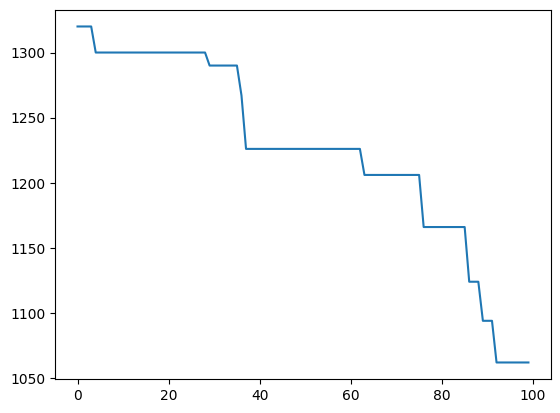

In [172]:
solucao = algoritmo_genetico_com_penalidades(dominio, tamanho_populacao = 10, numero_geracoes= 100)

In [173]:
print(solucao)

[2, 2, 0, 4, 0, 5, 2, 0, 3, 3, 3, 3, 1, 5, 2, 1, 5, 1, 0, 2, 0, 4, 1, 0, 4, 5, 5, 1, 5, 4, 0, 5, 2, 0, 5, 5, 4, 1, 1, 5, 2, 1, 1, 2, 2, 3, 4, 4, 1, 5, 1, 2, 2, 5, 5, 1, 0, 1, 2, 3, 1, 5, 0, 3, 2, 2, 2, 3, 1, 0, 4, 1, 3, 5, 5, 0, 0, 2, 0, 5, 3, 1, 1, 4, 2, 5, 4, 2, 5, 3, 2, 2, 2, 2, 4, 4, 4, 4, 5, 4, 4, 4, 5, 5, 1, 1, 4, 2, 3, 0, 3, 3, 1, 0, 2, 2, 1, 1, 5, 3, 0, 3, 3, 4, 0, 3, 1, 0, 2, 2, 3, 4, 3, 3, 0, 5, 2, 4, 0, 1, 2, 2, 2, 0, 4, 0, 3, 3, 4, 1]


In [174]:
funcao_avaliacao_com_penalidades(solucao)

1062

In [175]:
imprimir_qts(solucao)


1ª Turma:
|Segunda| MF, MF, NA, CO, NA, IA|
|Terça  | MF, NA, OC, OC, OC, OC|
|Quarta | SO, IA, MF, SO, IA, SO|
|Quinta | NA, MF, NA, CO, SO, NA|
|Sexta  | CO, IA, IA, SO, IA, CO|

2ª Turma:
|Segunda| NA, IA, MF, NA, IA, IA|
|Terça  | CO, SO, SO, IA, MF, SO|
|Quarta | SO, MF, MF, OC, CO, CO|
|Quinta | SO, IA, SO, MF, MF, IA|
|Sexta  | IA, SO, NA, SO, MF, OC|

3ª Turma:
|Segunda| SO, IA, NA, OC, MF, MF|
|Terça  | MF, OC, SO, NA, CO, SO|
|Quarta | OC, IA, IA, NA, NA, MF|
|Quinta | NA, IA, OC, SO, SO, CO|
|Sexta  | MF, IA, CO, MF, IA, OC|

4ª Turma:
|Segunda| MF, MF, MF, MF, CO, CO|
|Terça  | CO, CO, IA, CO, CO, CO|
|Quarta | IA, IA, SO, SO, CO, MF|
|Quinta | OC, NA, OC, OC, SO, NA|
|Sexta  | MF, MF, SO, SO, IA, OC|

5ª Turma:
|Segunda| NA, OC, OC, CO, NA, OC|
|Terça  | SO, NA, MF, MF, OC, CO|
|Quarta | OC, OC, NA, IA, MF, CO|
|Quinta | NA, SO, MF, MF, MF, NA|
|Sexta  | CO, NA, OC, OC, CO, SO|

Tempo Total de Espera Entre Aulas: 32 Horas


## Abordagem com Negação de Casos Indesejáveis

In [176]:
# CASO ALGUMA RESTRIÇÃO RETORNE VERDADEIRO HOUVE UMA QUEBRA DA RESTRIÇÃO
def verificar_restricoes(individuo):
  if verificar_aulas_esparsas(individuo):      # Restrição 2
    return True
  return False

### Taxa de Falha

In [177]:
def verificar_resistencia_falhas(turmas, qtd_dias_semana, disciplinas_dia):
  falhas, flag = 0, True
  while flag:
    individuo = gerar_cromossomo_sem_restricoes(turmas, qtd_dias_semana, disciplinas_dia, dominio[0])

    if verificar_restricoes(individuo):
      falhas += 1
    else:
      flag = False
  
  return falhas

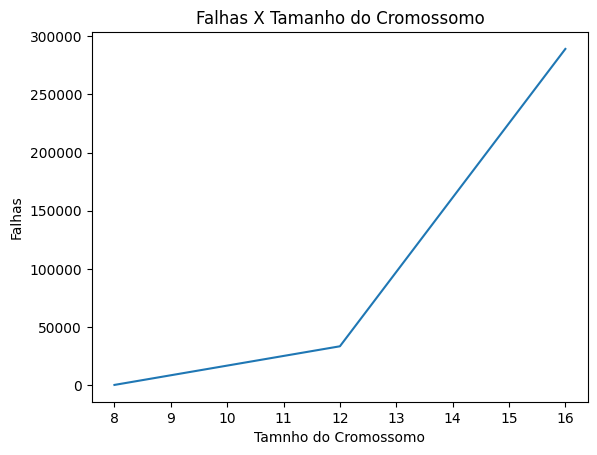

Falhas: 289111
Taxa de Falha: 99.99965411328482%


In [178]:
%matplotlib inline

falhas, historico_falhas = 0, []

teste_turmas, teste_qtd_dias_semana, teste_disciplinas_dia = 1, 4, 2
valores_parametro = list(range(teste_disciplinas_dia, teste_disciplinas_dia + 3))

for valor in valores_parametro:
  falhas = verificar_resistencia_falhas(teste_turmas, teste_qtd_dias_semana, valor)
  historico_falhas.append(falhas)

valores_parametro = [i * teste_turmas * teste_qtd_dias_semana for i in valores_parametro]

plt.xlabel('Tamnho do Cromossomo')
plt.ylabel('Falhas')
plt.title('Falhas X Tamanho do Cromossomo')
plt.plot(valores_parametro, historico_falhas)
plt.show()

print(f"Falhas: {falhas}\nTaxa de Falha: {falhas*100/(falhas+1)}%")

### Algoritmo Genético

Na prática a taxa de falhas elevada impede o algoritmo de gerar indivíduos válidos

In [179]:
# %matplotlib inline

# def algoritmo_genetico_sem_penalidades(dominio, tamanho_populacao = 10, passo = 1,
#                        elitismo = 0.2, numero_geracoes = 100, probabilidade_mutacao = 0.05):
  
#   falha_criacao_individuo = falha_crossover = count = 0
#   populacao = []
#   while count < tamanho_populacao:
#     #Cria aleatoriamente os indivíduos
#     individuo = gerar_cromossomo_sem_restricoes(curso["quantidade_turmas"], len(dias_semana), disciplinas_dia, dominio[0])
#     if verificar_restricoes(individuo):
#       falha_criacao_individuo += 1
#     else:
#       populacao.append(individuo)
#   #print(populacao)
#   #print(len(populacao))
#   numero_elitismo = int(elitismo * tamanho_populacao)

#   #print('Tamanho da população: ', len(populacao))

#   melhor_fit = []#Guardar o melhor de cada interação

#   for i in range(numero_geracoes):
#     custos = [(funcao_avaliacao_sem_penalidades(individuo), individuo) for individuo in populacao]
#     #print("A",custos)
#     custos.sort()
#     #print("B",custos)
#     individuos_ordenados = [individuo for (custo, individuo) in custos]
#     #print(individuos_ordenados)
#     populacao = individuos_ordenados[0:numero_elitismo] # só pega o percentual dos elementos baseados no elisitmo
    
#     while len(populacao) < tamanho_populacao:
#       i1 = random.randint(0, numero_elitismo)
#       i2 = random.randint(0, numero_elitismo)
#       #print(i1, i2, individuos_ordenados[i1], individuos_ordenados[i2])
#       novo_individuo = crossover(dominio, individuos_ordenados[i1], individuos_ordenados[i2])
#       #print(novo_individuo)
#       mutacao_novo_individuo = mutacao(dominio, passo, novo_individuo, probabilidade_mutacao)
#       #print(novo_individuo)
#       #print(mutacao_novo_individuo)
#       #print()
#       # if verificar_restricoes(mutacao_novo_individuo):
#       #   falha_crossover += 1
#       # else:
#       #   populacao.append(mutacao_novo_individuo)
#       populacao.append(mutacao_novo_individuo)

#     #print('Tamanho da população: ', len(populacao))
#     melhor_fit.append(custos[0][0])
#   #print(custos)
  
#   # print(melhor_fit)
#   #Plotar o gráfico
#   plt.plot(melhor_fit);

#   print(f"""População: {tamanho_populacao}\n
#   Rejeições na criação inicial de Individuos:{falha_criacao_individuo}\n
#   Rejeições no cruzamento de individuos: {falha_crossover}""")
  
#   return custos[0][1]

In [180]:
# solucao = algoritmo_genetico_sem_penalidades(dominio, tamanho_populacao = 10, numero_geracoes= 100)

In [181]:
# print(solucao)

In [182]:
# funcao_avaliacao_sem_penalidades(solucao)

In [183]:
# imprimir_qts(solucao)